# Synthetic Data

In [1]:
# Change working directory
%cd ..

d:\Optimal Transport\kfot


c:\Users\nguye\Apps\anaconda3\envs\ot-kpgf\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Disable warnings
import warnings
warnings.filterwarnings('ignore')

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import json
import numpy as np
import scipy
import os
import ot
import ot.plot
from optimal_transport.adapters import EMD
from optimal_transport.adapters.factored import KFOT, FOT, LOT
from optimal_transport.experiments.synthetic import gauss_mixture

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=16)
mpl.rc('ytick', labelsize=16)
plt.rcParams['figure.dpi'] = 300

In [3]:
# Generate data and settings
samples_per_cluster = 20
source, target, I, J = gauss_mixture(samples_per_cluster=samples_per_cluster)
X, Y = np.concatenate(source, axis=0), np.concatenate(target, axis=0)
a, b = np.ones(X.shape[0]) / X.shape[0], np.ones(Y.shape[0]) / Y.shape[0]
s = ["s","o","^"]
        
n_anchors = 3
n_keypoints = 3
k = 3
models = {
    "KFOT": KFOT(
        n_free_anchors=n_anchors, guide_mixing=0.5, stop_thr=1e-5,
        sinkhorn_reg=0.0005, temperature=0.01, div_term=1e-10, max_iters=200),
    "FOT": FOT(solver_kwargs={"r": n_anchors, "reg": 0.1}),
    "LOT": LOT(
        None, n_source_anchors=n_anchors, n_target_anchors=n_anchors, 
        epsilon=100, epsilon_z=100),
    "OT": EMD(solver_kwargs={"numItermax": 10000}),
}

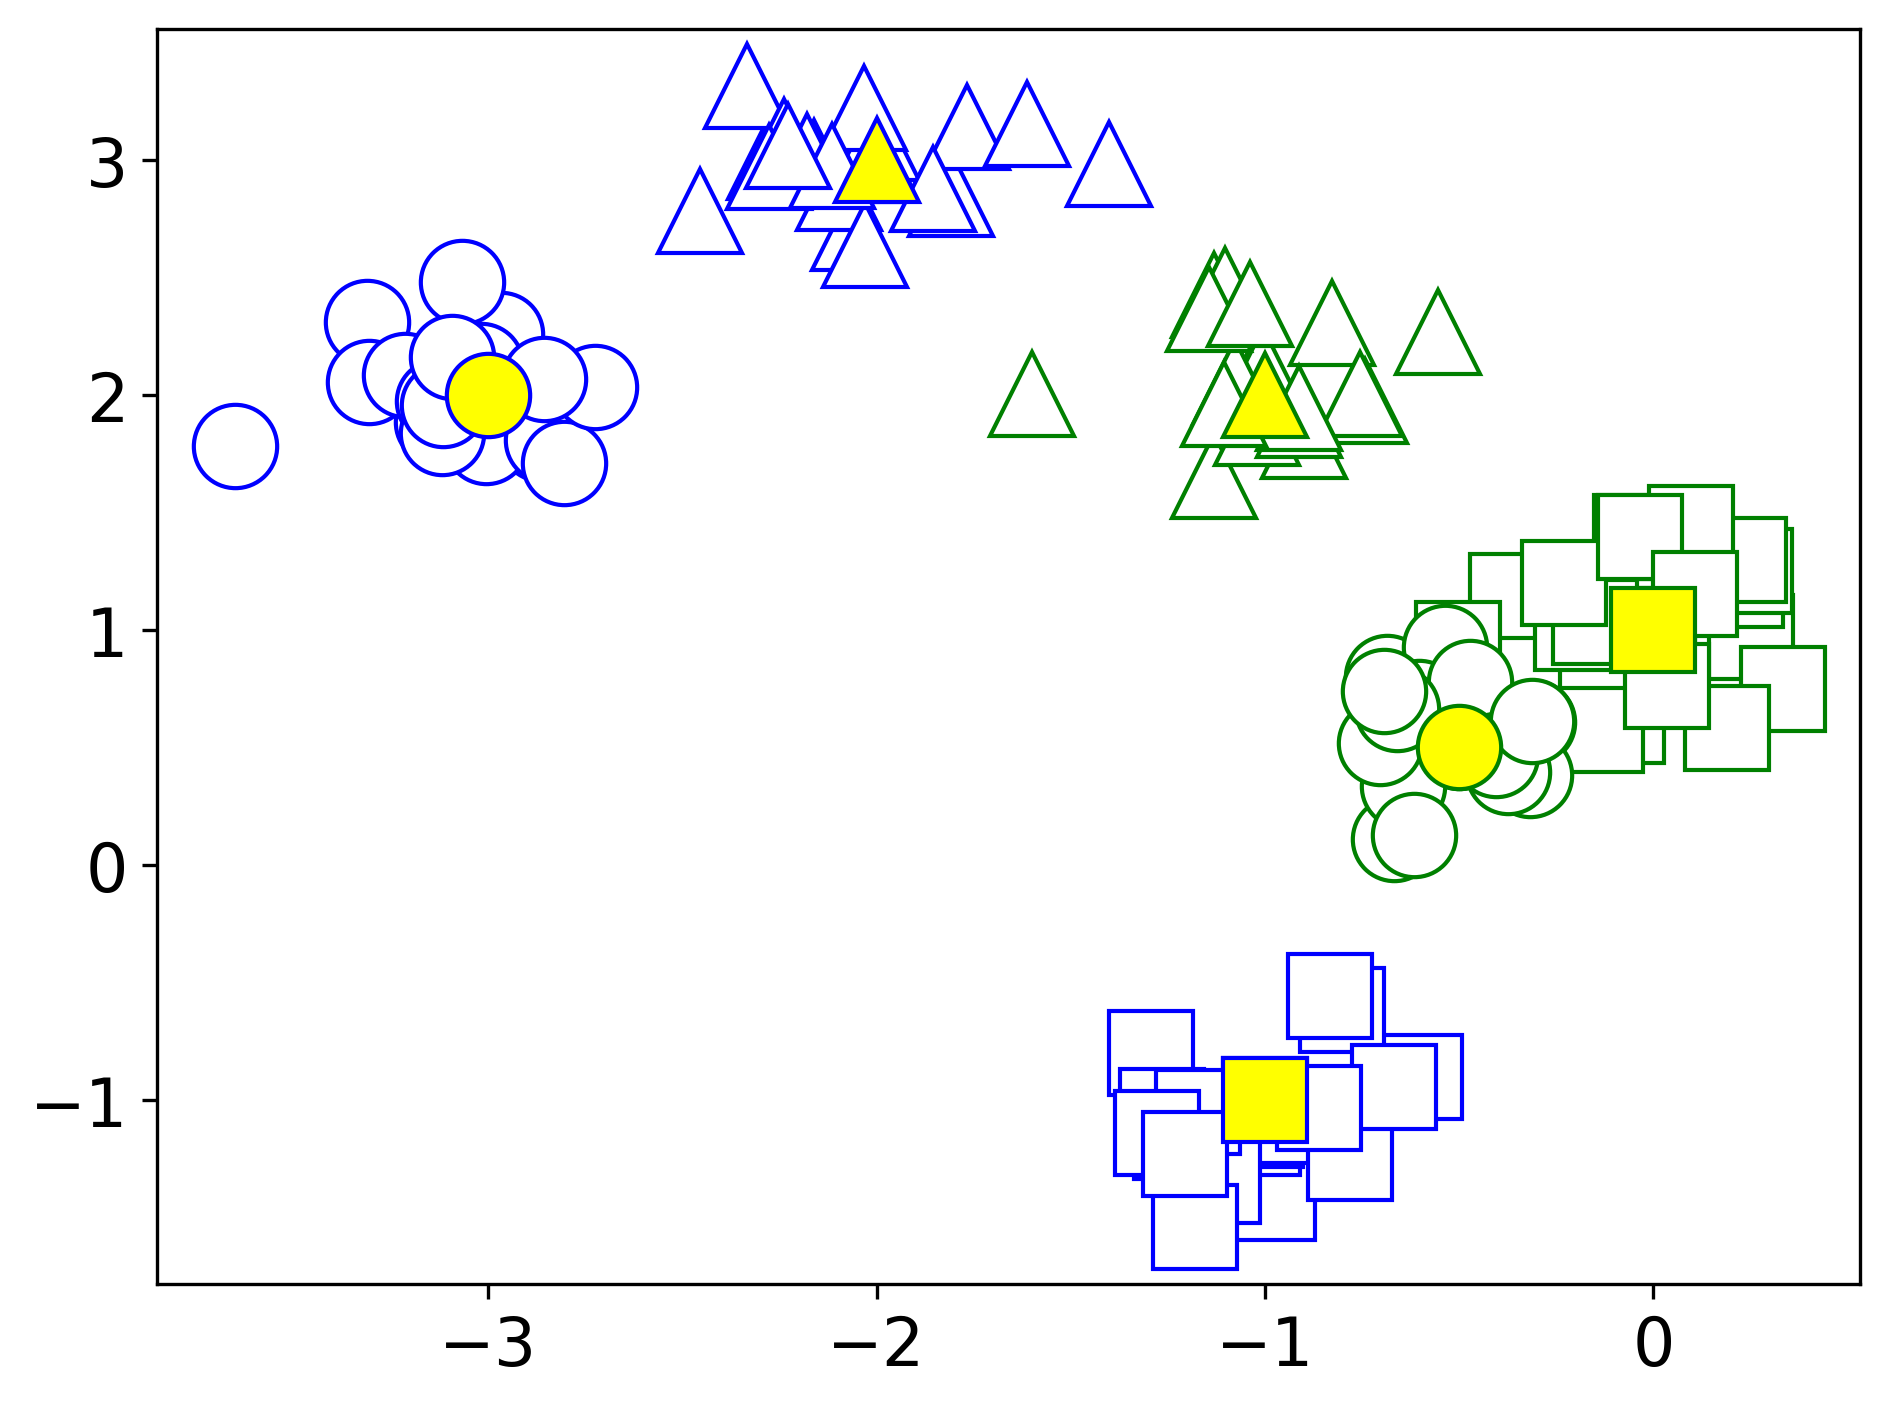

In [4]:
# plot the data
for i in range(3):
    plt.plot(source[i][:,0], source[i][:,1], 'b{}'.format(s[i]), markersize=20, markerfacecolor="white")
    plt.plot(target[i][:,0], target[i][:,1], 'g{}'.format(s[i]), markersize=20, markerfacecolor="white")

# plot keypoints
for i in range(len(I)):
    plt.plot(np.vstack(X)[I[i]][0], np.vstack(X)[I[i]][1],'b{}'.format(s[i]), markersize=20, markerfacecolor="yellow")
    plt.plot(np.vstack(Y)[J[i]][0], np.vstack(Y)[J[i]][1],'g{}'.format(s[i]), markersize=20, markerfacecolor="yellow")

plt.tight_layout()

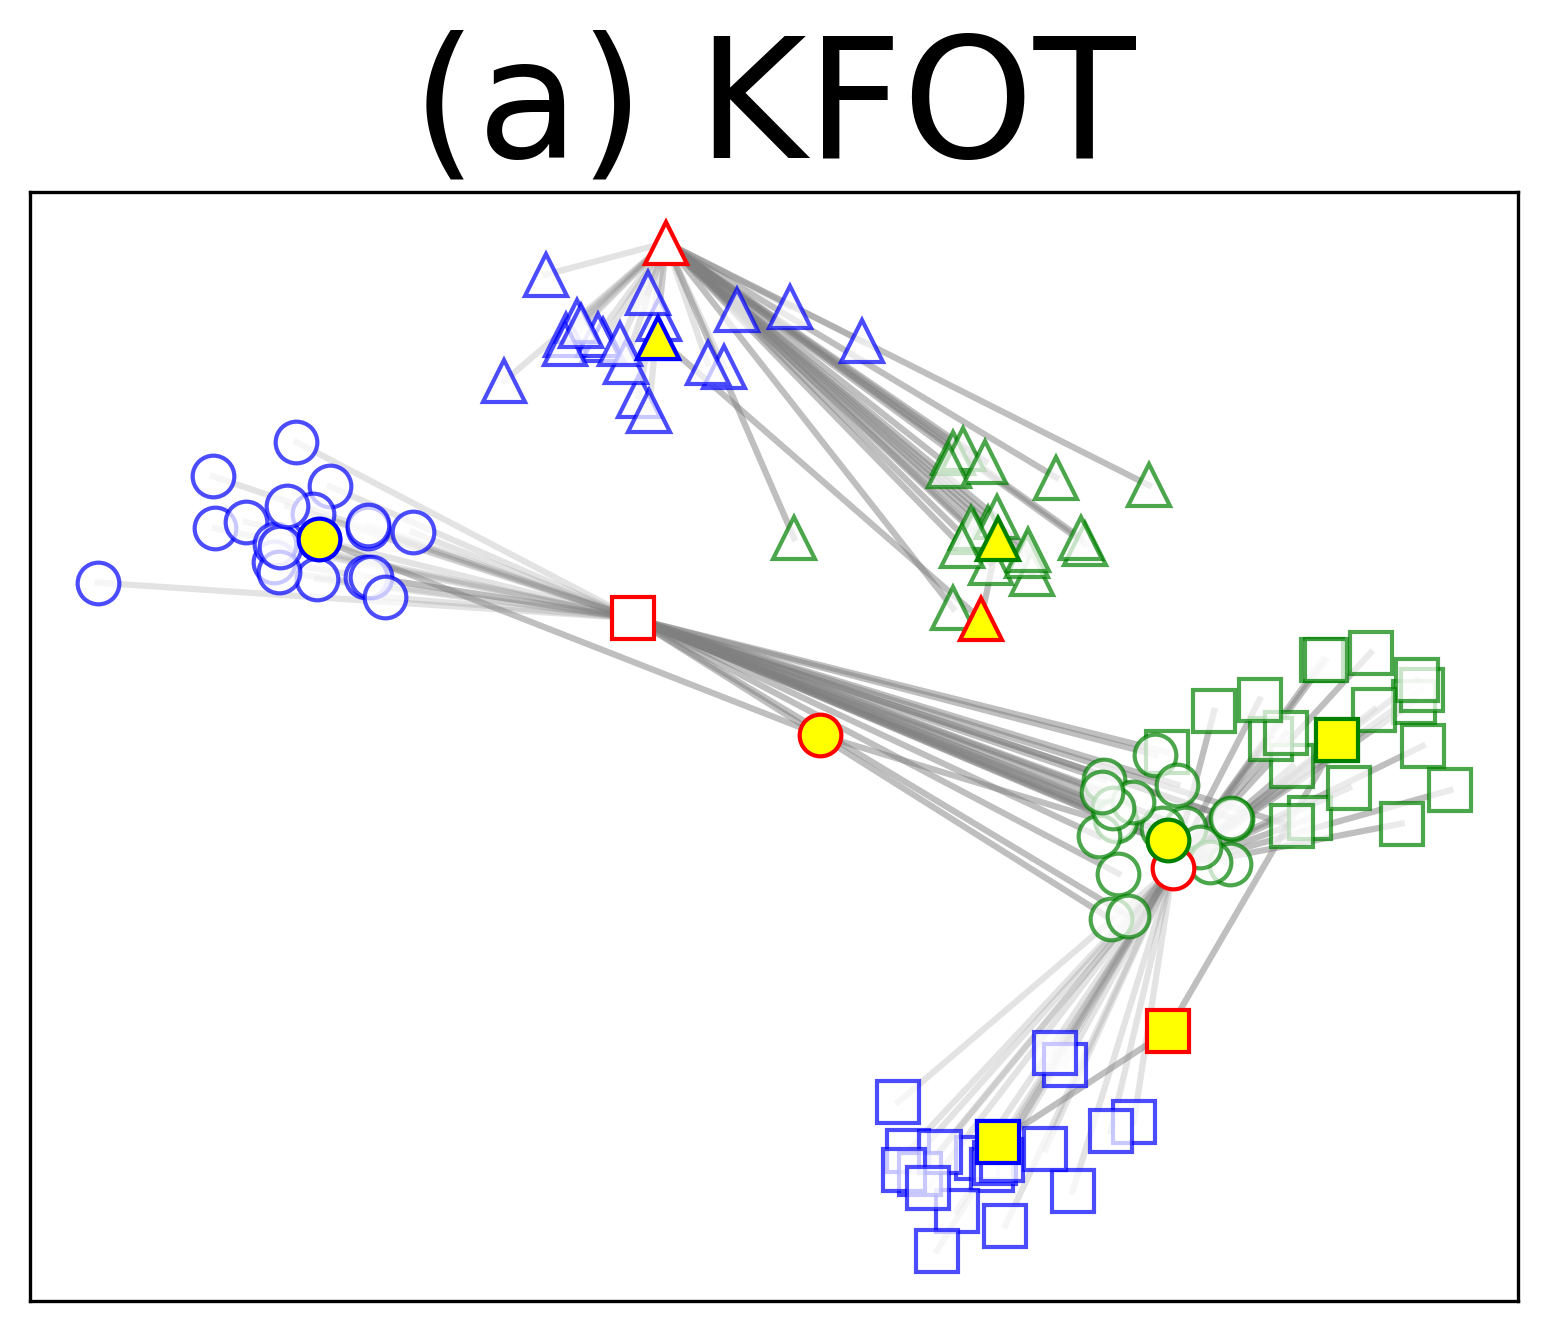

In [4]:
# KFOT
np.random.seed(1)
model: KFOT = models["KFOT"]
K = [(I[i], J[i]) for i in range(len(I))][:n_keypoints]
model.fit(X, Y, a, b, K=K)

# plot transport plan
ot.plot.plot2D_samples_mat(X, model.z_, np.clip(model.Pi_[0], 0, 0.02), c="grey", alpha=0.5)
ot.plot.plot2D_samples_mat(model.z_, Y, model.Pi_[1], c="grey", alpha=0.5)

# plot data
for i in range(3):
    plt.plot(source[i][:,0], source[i][:,1], 'b{}'.format(s[i]), markersize=10, markerfacecolor="white", alpha=0.7)
    plt.plot(target[i][:,0], target[i][:,1], 'g{}'.format(s[i]), markersize=10, markerfacecolor="white", alpha=0.7)

# plot anchor
j_, j__ = 0, 0
s_, s__ = [2, 0, 1], [0, 1, 2]
for i in range(n_anchors + n_keypoints):
    if i not in model.L_:
        plt.plot(model.z_[i][0], model.z_[i][1],'r{}'.format(s[s_[j_]]), markersize=10, markerfacecolor="white")
        j_ += 1
    else:
        plt.plot(model.z_[i][0], model.z_[i][1],'r{}'.format(s[s__[j__]]), markersize=10, markerfacecolor="yellow")
        j__ += 1

# plot keypoints
for i in range(len(I)):
    plt.plot(np.vstack(X)[I[i]][0], np.vstack(X)[I[i]][1],'b{}'.format(s[i]), markersize=10, markerfacecolor="yellow")
    plt.plot(np.vstack(Y)[J[i]][0], np.vstack(Y)[J[i]][1],'g{}'.format(s[i]), markersize=10, markerfacecolor="yellow")

# compute accuracy
P = model.P_
labels = [0]*samples_per_cluster + [1]*samples_per_cluster + [2]*samples_per_cluster
labels = np.array(labels)
pred = np.argmax(P, axis=1)
pred = labels[pred]
acc = np.mean(labels==pred)
#plt.text(-3.8,-0.5,"Matching\naccuracy: {:.1f}%".format(acc*100), fontsize=22)

plt.tick_params(
    axis='both',       # Apply to both x and y axes
    which='both',      # Apply to both major and minor ticks
    bottom=False,      # Turn off ticks on the bottom
    top=False,         # Turn off ticks on the top
    left=False,        # Turn off ticks on the left
    right=False,       # Turn off ticks on the right
    labelbottom=False, # Turn off labels on the bottom
    labelleft=False    # Turn off labels on the left
)
plt.title(fr"(a) KFOT", fontsize=40)
plt.show()

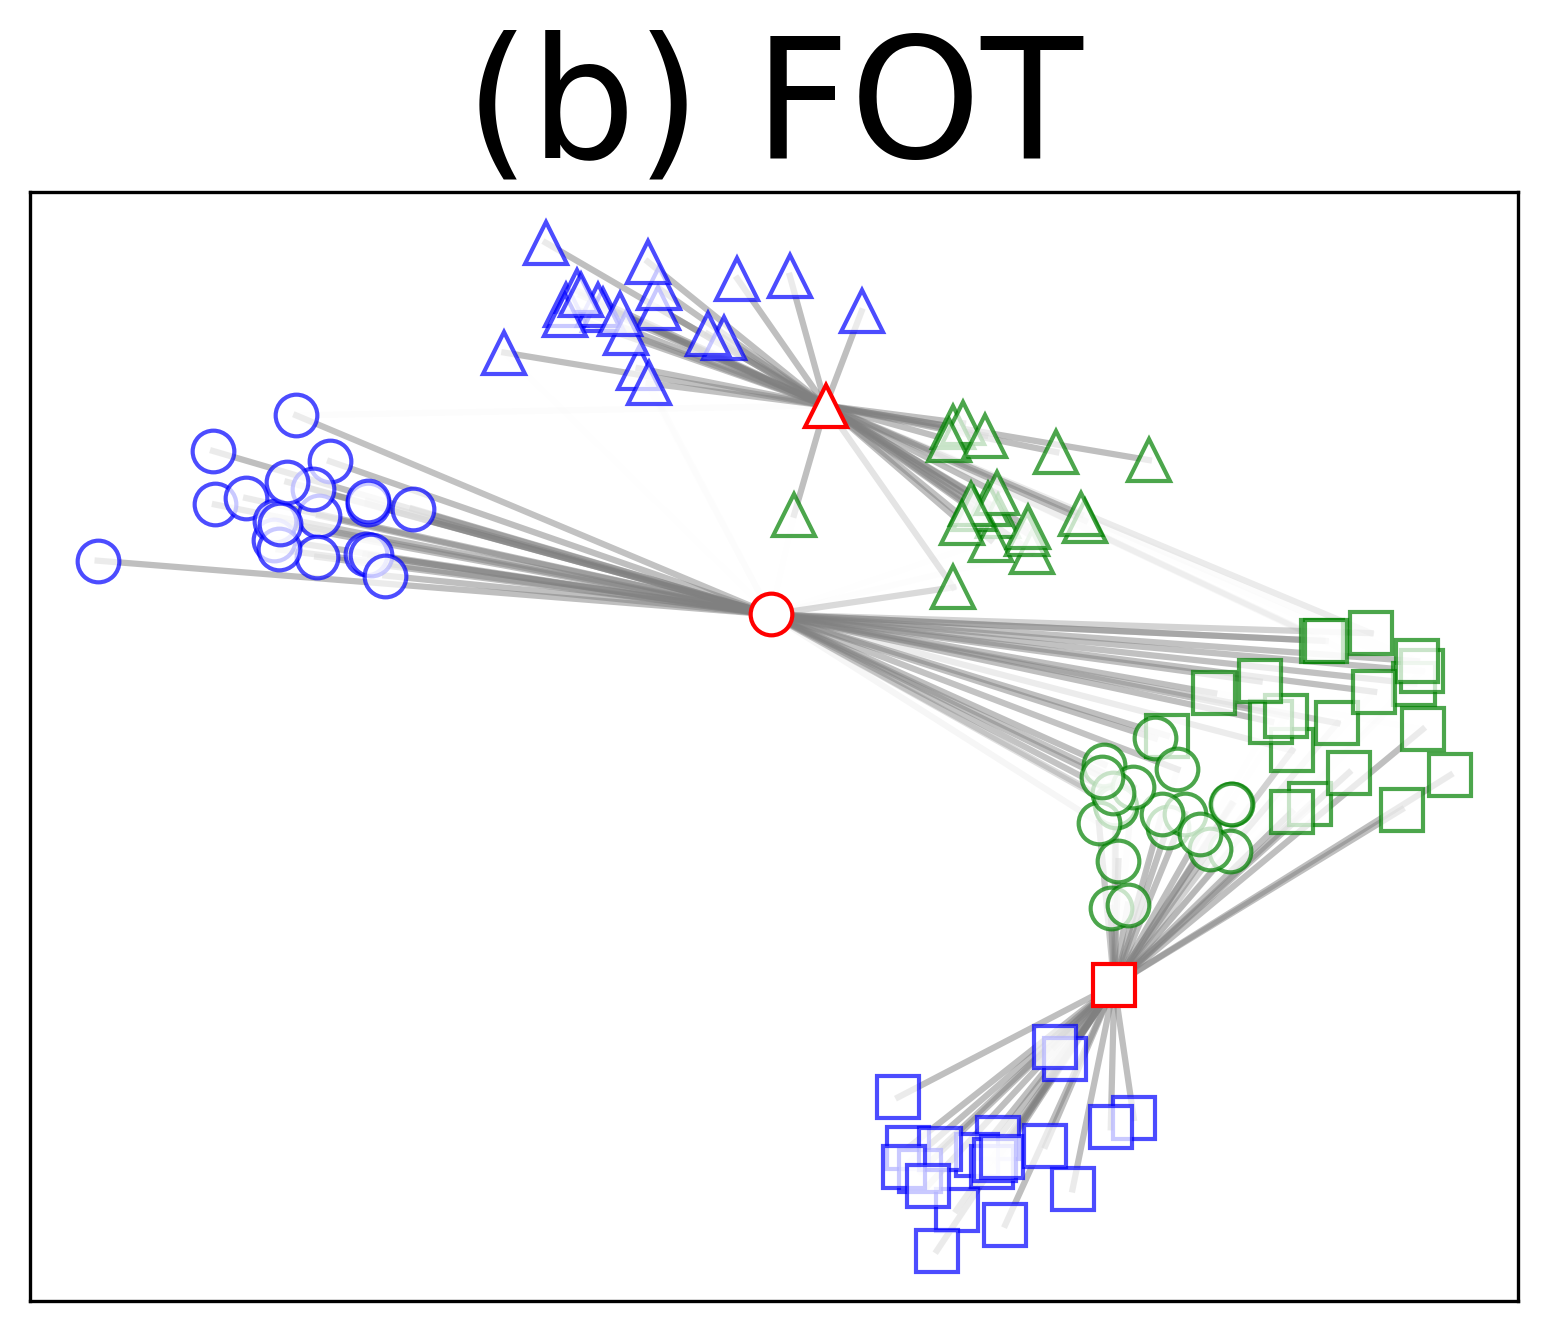

In [5]:
# FOT
np.random.seed(1)
model: FOT = models["FOT"]
model.fit(X, Y, a, b)

# plot transport plan
ot.plot.plot2D_samples_mat(X, model.z_, model.Pi_[0], c="grey", alpha=0.5)
ot.plot.plot2D_samples_mat(model.z_, Y, model.Pi_[1], c="grey", alpha=0.5)

# plot data
for i in range(3):
    plt.plot(source[i][:,0], source[i][:,1], 'b{}'.format(s[i]), markersize=10, markerfacecolor="white", alpha=0.7)
    plt.plot(target[i][:,0], target[i][:,1], 'g{}'.format(s[i]), markersize=10, markerfacecolor="white", alpha=0.7)

# plot anchor
j = 0
s_ = [1, 0, 2]
for i in range(n_anchors):
    plt.plot(model.z_[i][0], model.z_[i][1],'r{}'.format(s[s_[j]]), markersize=10, markerfacecolor="white")
    j += 1

# compute accuracy
P = model.P_
labels = [0]*samples_per_cluster + [1]*samples_per_cluster + [2]*samples_per_cluster
labels = np.array(labels)
pred = np.argmax(P, axis=1)
pred = labels[pred]
acc = np.mean(labels==pred)
#plt.text(-3.8,-0.5,"Matching\naccuracy: {:.1f}%".format(acc*100), fontsize=22)

plt.tick_params(
    axis='both',       # Apply to both x and y axes
    which='both',      # Apply to both major and minor ticks
    bottom=False,      # Turn off ticks on the bottom
    top=False,         # Turn off ticks on the top
    left=False,        # Turn off ticks on the left
    right=False,       # Turn off ticks on the right
    labelbottom=False, # Turn off labels on the bottom
    labelleft=False    # Turn off labels on the left
)
plt.title(fr"(b) FOT", fontsize=40)
plt.show()

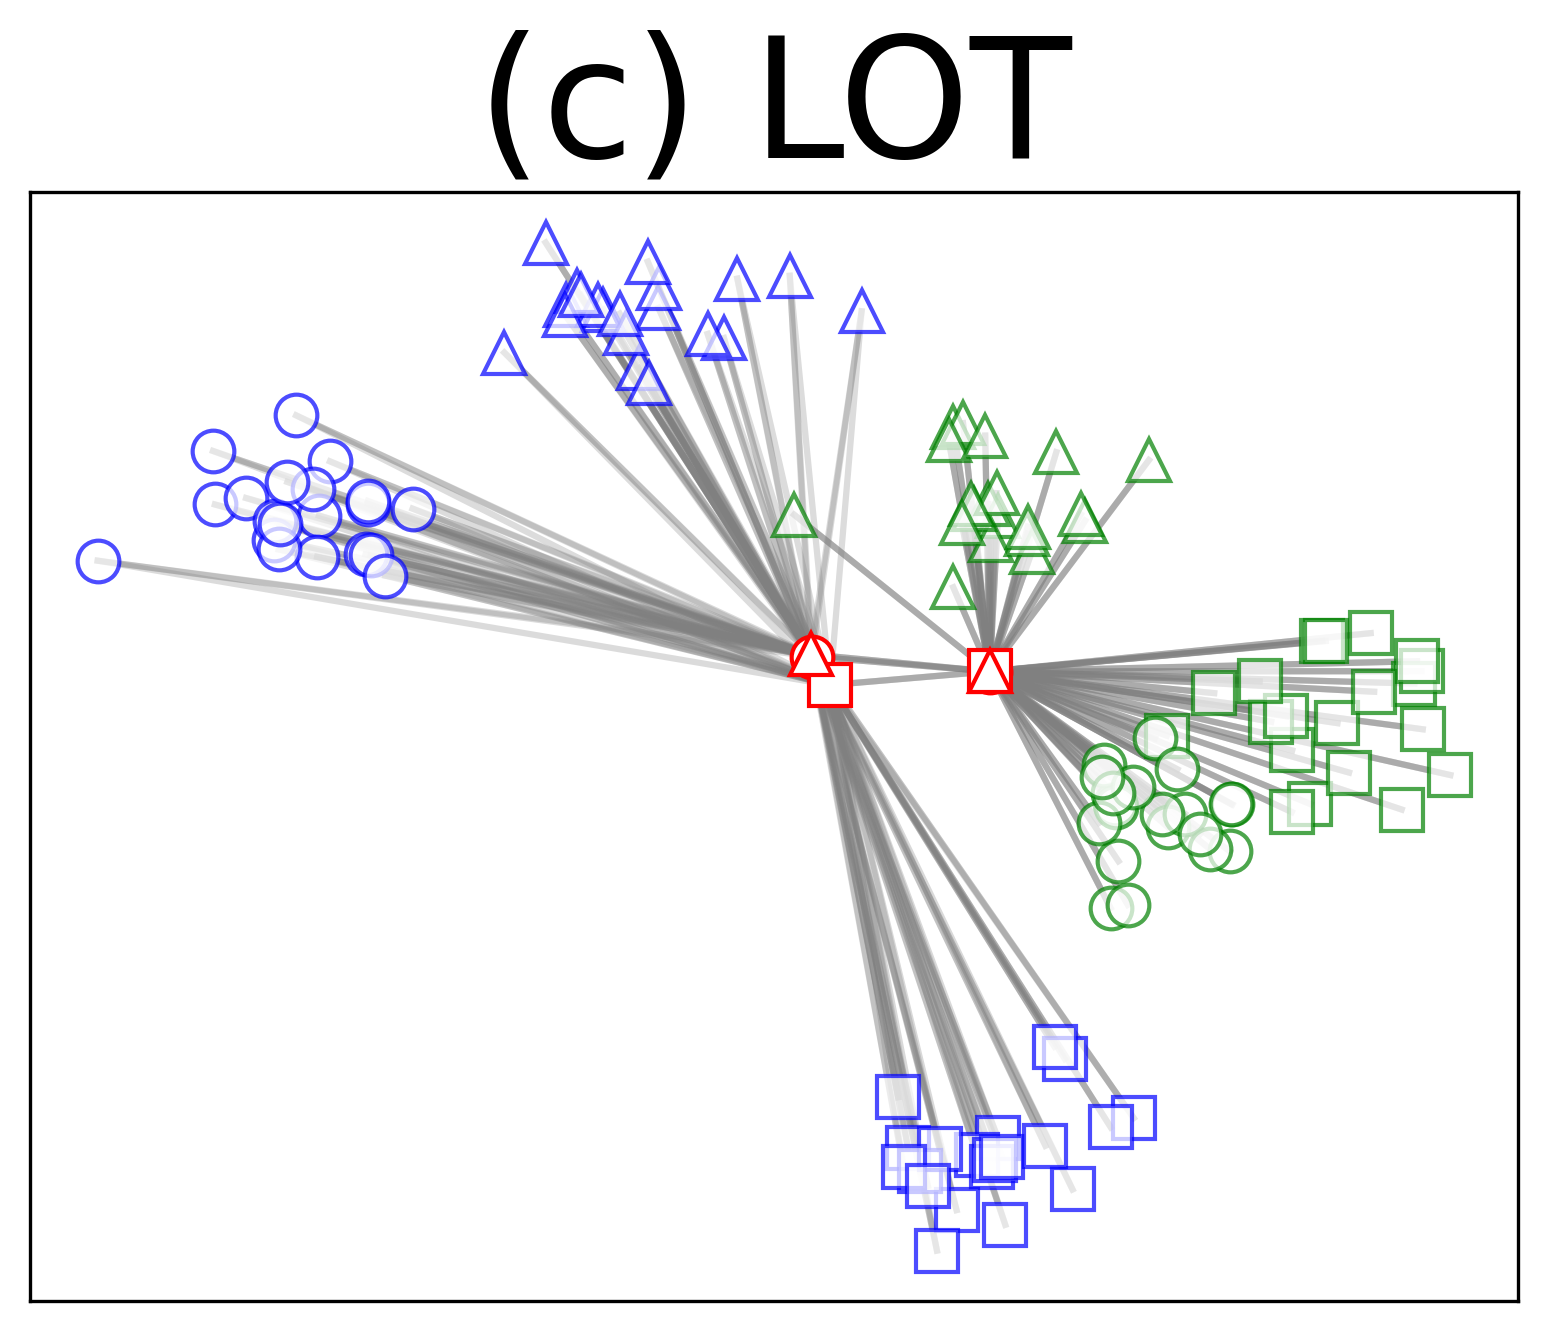

In [6]:
# LOT
np.random.seed(2)
model: LOT = models["LOT"]
model.fit(X, Y, a, b)

# plot transport plan
ot.plot.plot2D_samples_mat(X, model.Cx, model.Pi_[0], c="grey", alpha=0.3)
ot.plot.plot2D_samples_mat(model.Cx, model.Cy, model.Pi_[2], c="grey", alpha=0.3)
ot.plot.plot2D_samples_mat(model.Cy, Y, model.Pi_[1], c="grey", alpha=0.3)

# plot data
for i in range(3):
    plt.plot(source[i][:,0], source[i][:,1], 'b{}'.format(s[i]), markersize=10, markerfacecolor="white", alpha=0.7)
    plt.plot(target[i][:,0], target[i][:,1], 'g{}'.format(s[i]), markersize=10, markerfacecolor="white", alpha=0.7)

# plot anchor
j = 0
s_ = [1, 0, 2]
for i in range(n_anchors):
    plt.plot(model.Cx[i][0], model.Cx[i][1],'r{}'.format(s[s_[j]]), markersize=10, markerfacecolor="white")
    plt.plot(model.Cy[i][0], model.Cy[i][1],'r{}'.format(s[s_[j]]), markersize=10, markerfacecolor="white")
    j += 1

# compute accuracy
P = model.P_
labels = [0]*samples_per_cluster + [1]*samples_per_cluster + [2]*samples_per_cluster
labels = np.array(labels)
pred = np.argmax(P, axis=1)
pred = labels[pred]
acc = np.mean(labels==pred)
#plt.text(-3.8,-0.5,"Matching\naccuracy: {:.1f}%".format(acc*100), fontsize=22)

plt.tick_params(
    axis='both',       # Apply to both x and y axes
    which='both',      # Apply to both major and minor ticks
    bottom=False,      # Turn off ticks on the bottom
    top=False,         # Turn off ticks on the top
    left=False,        # Turn off ticks on the left
    right=False,       # Turn off ticks on the right
    labelbottom=False, # Turn off labels on the bottom
    labelleft=False    # Turn off labels on the left
)
plt.title(fr"(c) LOT", fontsize=40)
plt.show()

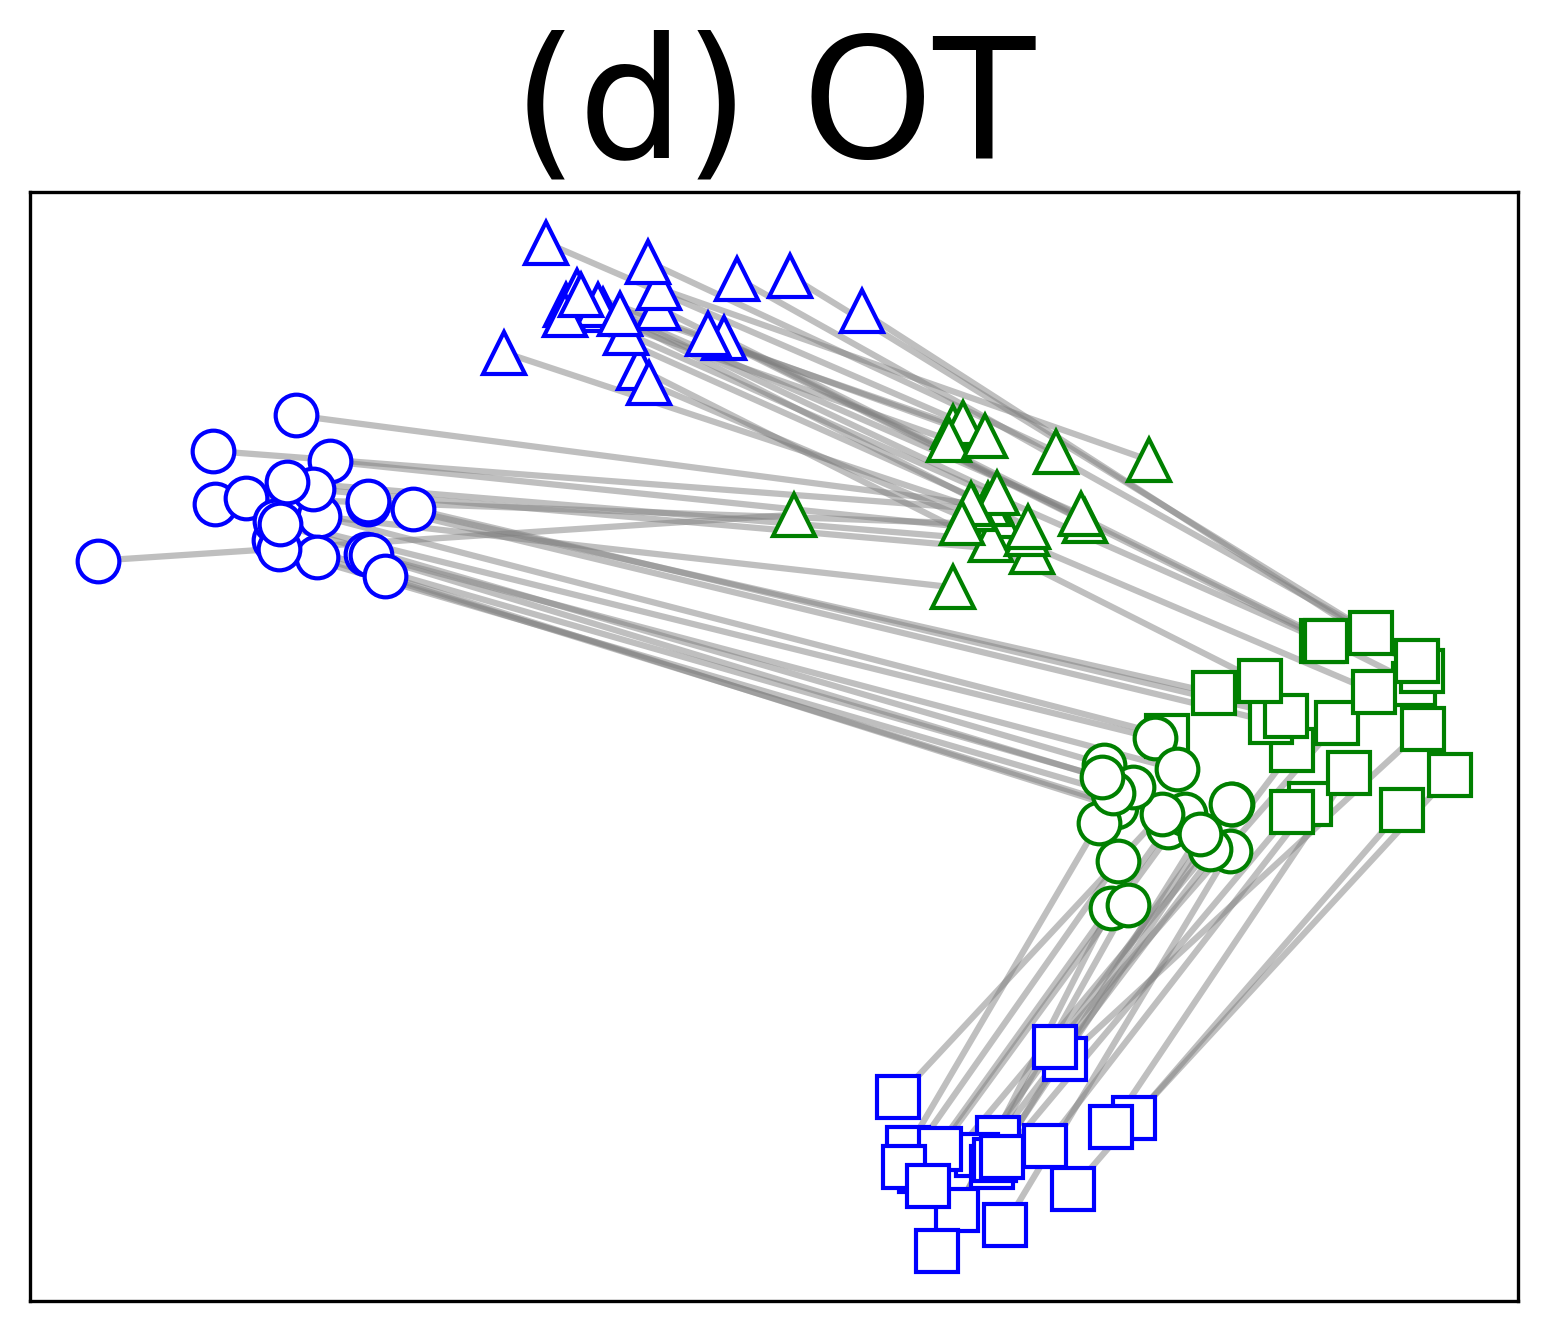

In [7]:
# EMD
np.random.seed(1)
model: EMD = models["OT"]
model.fit(X, Y, a, b)

# plot transport plan
ot.plot.plot2D_samples_mat(X, Y, model.P_, c="grey", alpha=0.5)

# plot data
for i in range(3):
    plt.plot(source[i][:,0], source[i][:,1], 'b{}'.format(s[i]), markersize=10, markerfacecolor="white")
    plt.plot(target[i][:,0], target[i][:,1], 'g{}'.format(s[i]), markersize=10, markerfacecolor="white")

# compute accuracy
P = model.P_
labels = [0]*samples_per_cluster + [1]*samples_per_cluster + [2]*samples_per_cluster
labels = np.array(labels)
pred = np.argmax(P, axis=1)
pred = labels[pred]
acc = np.mean(labels==pred)
#plt.text(-3.8,-0.5,"Matching\naccuracy: {:.1f}%".format(acc*100), fontsize=22)

plt.tick_params(
    axis='both',       # Apply to both x and y axes
    which='both',      # Apply to both major and minor ticks
    bottom=False,      # Turn off ticks on the bottom
    top=False,         # Turn off ticks on the top
    left=False,        # Turn off ticks on the left
    right=False,       # Turn off ticks on the right
    labelbottom=False, # Turn off labels on the bottom
    labelleft=False    # Turn off labels on the left
)
plt.title(fr"(d) OT", fontsize=40)
plt.show()